<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_1_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Processing and Sentiment Analysis for Twitter##


In [0]:
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import tweepy #tweeter python package
import re
import en_core_web_sm #(python -m spacy download en_core_web_lg) # pre-train model sm: small
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


% matplotlib inline

###1. NLP###
Spacy package

In [0]:
nlp = en_core_web_sm.load()  # spacy language model

doc1 = nlp(u'NJ Princeton Public Library is awesome. Enter https://princetonlibrary.org/')

for token in doc1: # parse each word and make token
    
    print(token.text) #Text: The original word text.
    #print(token.lemma) #Lemma: The base form of the word.
    #print(token.pos_) #POS: The simple part-of-speech tag.
    #print(token.tag_) #Tag: The detailed part-of-speech tag.
    #print(token.dep_) #Dep: Syntactic dependency, i.e. the relation between tokens.
    #print(token.shape_) #Shape: The word shape – capitalisation, punctuation, digits.
    #print(token.is_alpha) #is alpha: Is the token an alpha character?
    #print(token.is_stop) #is stop: Is the token part of a stop list, i.e. the most common words of the language?

NJ
Princeton
Public
Library
is
awesome
.
Enter
https://princetonlibrary.org/


In [0]:
displacy.render(doc1, style='ent',jupyter = True) #Visualizing the entity recognizer

In [0]:
text = """But Google is starting from behind. The company made a late push
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa
software, which runs on its Echo and Dot devices, have clear leads in
consumer adoption."""

doc2 = nlp(text)
displacy.render(doc2, style='ent', jupyter=True)

In [0]:
displacy.render(doc1, style='dep',jupyter = True) #Spacy dependency visualizer

In [0]:
options = {'compact': True, 'bg': '#09a3d5',
           'color': 'white', 'font': 'Source Sans Pro'}
displacy.render(doc1, style='dep', jupyter = True, options=options)


In [0]:
token_exemple = doc1[0]
token_exemple

NJ

In [0]:
token_exemple.ent_type_

'ORG'

In [0]:
token_exemple.is_stop

False

In [0]:
[x for x in doc1 if x.text not in spacy.lang.en.stop_words.STOP_WORDS]


[NJ,
 Princeton,
 Public,
 Library,
 awesome,
 .,
 Enter,
 https://princetonlibrary.org/]

In [261]:
# print stop words from spacy
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(stopwords)

{'see', 'another', 'none', 'did', 'any', 'herself', 'become', 'bottom', 'say', 'an', 'back', 'since', 'four', 'whereafter', 'along', 'somehow', 'their', 'had', 'hers', 'although', 'per', 'many', 'with', 'therein', 'hereafter', 'mostly', 'nevertheless', 'a', 'if', 'than', 'behind', 'where', 'anyone', 'always', 'amongst', 'own', 'seem', 'there', 'some', 'you', 'whence', 'least', 'everyone', 'over', 'same', 'only', 'latter', 'up', 'too', 'yourselves', 'how', 'no', 'onto', 'by', 'his', 'should', 'during', 'about', 'fifteen', 'nor', 'him', 'now', 'as', 'used', 'whoever', 'into', 'nowhere', 'whether', 'other', 'several', 'do', 'this', 'so', 'meanwhile', 'seems', 'more', 'around', 'am', 'does', 'themselves', 'to', 'until', 'formerly', 'yet', 'five', 'it', 'then', 'they', 'nobody', 'herein', 'ever', 'for', 'or', 'thereupon', 'anyhow', 'myself', 'almost', 'former', 'has', 'everything', 'alone', 'however', 'top', 'may', 'very', 'them', 'below', 'eleven', 'unless', 'ours', 'twenty', 'quite', 'suc

Add word into stop_work list

In [0]:
# check stop words
w = 'https'
nlp.vocab[w].is_stop = True

In [0]:
nlp('https')[0].is_stop

True

In [0]:
# print token
print(token_exemple.vector[:10])
len(token_exemple.vector)

[-1.3438694   2.2110689   2.960999    5.1636534   0.09328234  4.1673794
  1.0691484  -1.2223803   1.5614059   1.0312486 ]


384

In [0]:
doc3 = nlp('I am feeling blue')
doc4 = nlp('the sky is blue')
doc5 = nlp('I am sad')


print(doc2[-1].vector[0])
print(doc3[-1].vector[0]) 
print(doc4[-1].vector[0]) 

1.6701834
-1.049581
-1.1331878


In [0]:
len(doc2[-1].vector)

384

Similarity analysis



In [0]:
print('The similarity between doc 3 and doc 4 is {}'.format(doc3.similarity(doc4)))
print('The similarity between doc 4 and doc 5 is {}'.format(doc4.similarity(doc5)))



The similarity between doc 3 and doc 4 is 0.5246592405896248
The similarity between doc 4 and doc 5 is 0.4329018029459278


TextBlob vs Spacy sentiment analysis

In [0]:
print('Spacy\'s sentiment analysis result is {}'.format(doc5.sentiment))

print('TextBlob\'s sentiment analysis result is {}'.format(TextBlob('I am sad').sentiment))


Spacy's sentiment analysis result is 0.0
TextBlob's sentiment analysis result is Sentiment(polarity=-0.5, subjectivity=1.0)


The following functions are wrangling the data from tweeter

In [0]:
class connection_twitter():
    def __init__(self,consumer_key, consumer_secret, access_token, access_token_secret, keyword):
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        self.api = tweepy.API(auth)
        self.key_word = [keyword]

        return None


#%%
# Structure the tweets

    def get_info(self,tweet):
        id = tweet.id
        text_ = tweet.full_text
        author = tweet.author
        date = tweet.created_at
        location = tweet.coordinates
        favorite_count = tweet.favorite_count

        user_favorite_count = tweet.user.favourites_count
        user_followers_count = tweet.user.followers_count
        user_location = tweet.user.location

        return id, text_, author, date, location, favorite_count, user_favorite_count, user_followers_count, user_location


    def get_texts(self):

        all_results = []
        for i in range(len(self.key_word)):
            tweets = tweepy.Cursor(self.api.search, q=self.key_word, lang = "en",tweet_mode='extended').items(100)
            result = [tweet for tweet in tweets]
            all_results.append(result)

        for i in range(len(all_results)):
            if i == 0:
                tweet_data = pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]])

            else:
                tweet_data = pd.concat([pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]]), tweet_data])

        tweet_data.columns = ['id', 'text_', 'author', 'date', 'location', 'favorite_count', 'user_favorite_count', 'user_followers_count', 'user_location']

        return tweet_data


<h1>Twitter Analysis</h1>
<p>Now let's assess one public debate on twitter. The keyword we are going to use is "Wall"</p>

In [309]:
consumer_key = 'oxzQOYB3Yh1cTezTa0X9yYWaB'
consumer_secret = 'tL7HzTqiORDEvnzSq5ghsOwl9wl2ntlPT5Q8opdGMErltW1dr5'
access_token = '3579562937-XxUFCW12vuqHwjifqx0YTOAi8xzRKvIWPZsx5DV'
access_token_secret = '9b0WGTWIrSQZY7QAWtpXuZEkEKrKjKpKPcm70BFb9XrkD'
#keyword = 'harmony'
keyword = 'Colgate Total'

twitter = connection_twitter(consumer_key,consumer_secret,access_token,access_token_secret,keyword)

data = twitter.get_texts()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 9 columns):
id                      80 non-null int64
text_                   80 non-null object
author                  80 non-null object
date                    80 non-null datetime64[ns]
location                0 non-null object
favorite_count          80 non-null int64
user_favorite_count     80 non-null int64
user_followers_count    80 non-null int64
user_location           80 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 5.7+ KB


Sentiment analysis in the tex column using TextBlob

In [0]:
data['Polarity'] = [TextBlob(x).sentiment[0] for x in data['text_'] ]
data['Subjectivity'] = [TextBlob(x).sentiment[1] for x in data['text_'] ]

In [311]:
#https://developer.twitter.com/content/developer-twitter/en.html
data.head(5)
#len(data)

,id,text_,author,date,location,favorite_count,user_favorite_count,user_followers_count,user_location,Polarity,Subjectivity
0,1106262307582238726,Are you a little extra? So am I. So is my toot...,User(_api=<tweepy.api.API object at 0x7f1586d9...,2019-03-14 18:34:22,None,0,6448,2732,"North Carolina, USA",0.078125,0.362500
1,1106262191898947584,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d9...,2019-03-14 18:33:54,None,0,6248,946,Intarweb,0.178788,0.601515
2,1106258714057678851,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d9...,2019-03-14 18:20:05,None,0,6,33513,The sale rack in Wilmington NC,0.178788,0.601515
3,1106256883021680641,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d9...,2019-03-14 18:12:48,None,0,8429,20973,NC,0.178788,0.601515
4,1106250147736907776,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d9...,2019-03-14 17:46:03,None,0,3780,35953,"Florida now, London forever",0.178788,0.601515


In [293]:
#data.groupby('user_location').sum().sort_values(["user_favorite_count", "user_followers_count"],ascending=False)
data1 = data.groupby('user_location').sum().sort_values(["Polarity"],ascending=False)
data1.head(5)

,id,favorite_count,user_favorite_count,user_followers_count,Polarity,Subjectivity
user_location,,,,,,
,1.656896e+19,13.0,153530.0,308756.0,1.721860,6.849781
United Kingdom,3.311948e+18,1.0,3966.0,45411.0,0.472527,1.892298
Malaysia,1.105150e+18,0.0,2892.0,503.0,0.341667,0.537500
"San Francisco, CA",1.105216e+18,1.0,131431.0,547.0,0.271429,0.421429
"Mumbai, India",1.105436e+18,0.0,298.0,6016.0,0.259091,0.626136


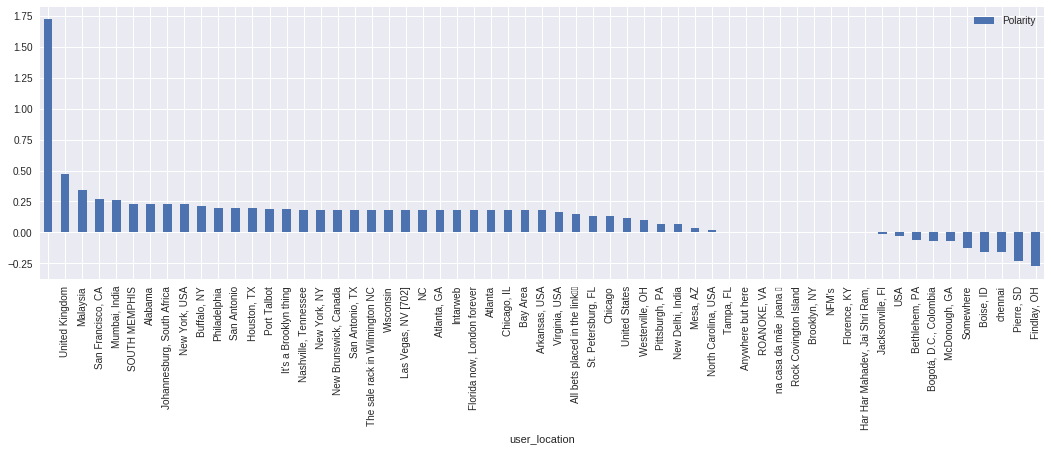

In [294]:
data1[['Polarity']].plot(kind='bar', figsize=(18, 5), legend=True)

In [295]:
#print(data['text_'][5])
#print(data['user_location'][5])
data.iloc[64,:]

id                                                    1104021204057374721
text_                   @HighAndlnside Ask Jack. It's called Colgate T...
author                  User(_api=<tweepy.api.API object at 0x7f1586d7...
date                                                  2019-03-08 14:09:01
location                                                             None
favorite_count                                                          1
user_favorite_count                                                 37826
user_followers_count                                                  505
user_location                                       Rock Covington Island
Polarity                                                                0
Subjectivity                                                         0.75
Name: 64, dtype: object

Try wordcloud
pre-process text column

In [296]:
#len(data['text_'])
data.head()

,id,text_,author,date,location,favorite_count,user_favorite_count,user_followers_count,user_location,Polarity,Subjectivity
0,1106262307582238726,Are you a little extra? So am I. So is my toot...,User(_api=<tweepy.api.API object at 0x7f1586d7...,2019-03-14 18:34:22,None,0,6448,2732,"North Carolina, USA",0.078125,0.362500
1,1106262191898947584,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d7...,2019-03-14 18:33:54,None,0,6248,946,Intarweb,0.178788,0.601515
2,1106258714057678851,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d7...,2019-03-14 18:20:05,None,0,6,33513,The sale rack in Wilmington NC,0.178788,0.601515
3,1106256883021680641,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d7...,2019-03-14 18:12:48,None,0,8429,20973,NC,0.178788,0.601515
4,1106250147736907776,RT @ParentPalace: Looking for a toothpaste tha...,User(_api=<tweepy.api.API object at 0x7f1586d7...,2019-03-14 17:46:03,None,0,3780,35953,"Florida now, London forever",0.178788,0.601515


In [0]:
data['text_clean'] = data['text_']

In [302]:
data['text_'][1].split(' ')

['RT',
 '@ParentPalace:',
 'Looking',
 'for',
 'a',
 'toothpaste',
 'that',
 'can',
 '#DoMoreForYourWholeMouth?',
 'Click',
 'to',
 'learn',
 'about',
 'new',
 'Colgate',
 'Total',
 'Advanced',
 'Whitening',
 'Too…']

Remove punctuations, double space; put in lower case

In [0]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('  ', ' ', x))

In [303]:
# remove URLs, other words, and twitter handles

for i in range(len(data['text_'])):

    data['text_clean'][i] = " ".join([word for word in data['text_clean'][i].split(' ')
                                    if 'http' not in word \
                                      and '@' not in word \
                                      and '#' not in word\
                                      and '\n' not in word\
                                      and 'rt' not in word \
                                      and 'colgate' not in word
                                     and 'total' not in word
                                     and 'toothpaste' not in word])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [304]:
data['text_clean']

0     are you a little extra so am i so is my i rece...
1     parentpalace looking for a that can domorefory...
2     parentpalace looking for a that can domorefory...
3     parentpalace looking for a that can domorefory...
4     parentpalace looking for a that can domorefory...
5     parentpalace looking for a that can domorefory...
6     parentpalace looking for a that can domorefory...
7     parentpalace looking for a that can domorefory...
8     parentpalace looking for a that can domorefory...
9     parentpalace looking for a that can domorefory...
10    parentpalace looking for a that can domorefory...
11    parentpalace looking for a that can domorefory...
12    parentpalace looking for a that can domorefory...
13    parentpalace looking for a that can domorefory...
14    parentpalace looking for a that can domorefory...
15    parentpalace looking for a that can domorefory...
16    parentpalace looking for a that can domorefory...
17    mikevacc snytv ripoff mike - i was wonderi

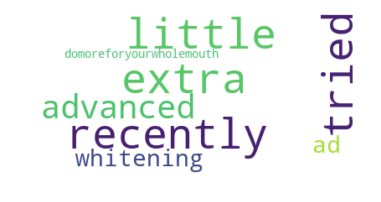

In [305]:
mpl.rcParams['figure.figsize']=(6.0,4.0)    #(6.0,4.0)
mpl.rcParams['font.size']=8               #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

#wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data[][0])


stopwords1 = set(stopwords)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords1,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(data['text_clean'][0])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


#print(wordcloud)
#fig = plt.figure(1)
#fig.savefig("word1.png", dpi=900)

In [306]:
print(data['text_clean'][0])

are you a little extra so am i so is my i recently tried out the advanced whitening ad domoreforyourwholemouth


Print postive word by wordcloud

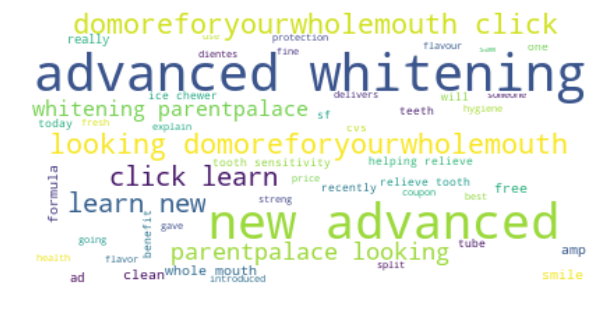

In [307]:
text_pro = ''
for text in data[data['Polarity']>0]['text_clean']:
  
  text_pro = text_pro + ' ' + text

#text_pro


wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text_pro)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  


print negative words by wordcloud

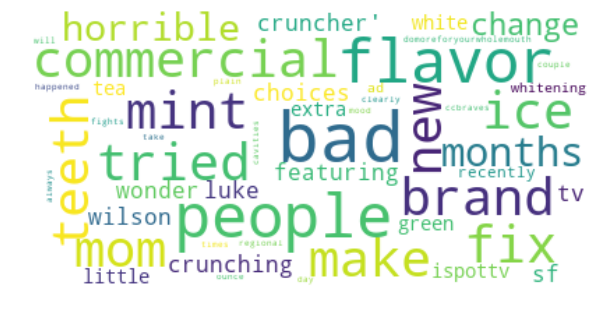

In [308]:
text_negative = ''
for text in data[data['Polarity']<0]['text_clean']:
  
  #if text not in spacy.lang.en.stop_words.STOP_WORDS:
  text_negative = text_negative + ' ' + text


text_negative

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text_negative)

plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  
 

In [312]:
text_negative

' isn\'t crunching ice bad for your teeth makes you wonder about their brand/choices sf tv commercial \'ice cruncher\' featuring luke wilson - ispottv white with green tea mint are you a little extra so am i so is my i recently tried out the whitening ad domoreforyourwholemouth ccbraves it’s happened to me a couple of times my 40 ounce both fights cavities and clearly will take down a plain always a regional too the other day i was in a bad mood so my mom offered to buy me some yeah mom some is gonna fix all my problems new post cvs mouthwash 500ml 99c/u *reg 549c/u* [termina [03/16/19] commercials representing "i\'m an asshole" and people just have to deal with my bad habits doesn\'t really spread a positive message don\'t find humor in making people vasan_bala vicky_donorr many asking for to make the opposite side of in all the tweets they haven\'t watch the advt intolerance and annoying the politicians made the people for their benefit i am sorry for those who are educated but still